In [1]:
%cd ..

/Users/pedrobedmar/GoogleDrive/MASTER_BIG_DATA/tfm/code


In [2]:
import numpy as np
import pandas as pd

from etl.esios.provider import ESIOSDataProvider
from etl.generic_provider import GenericDataProvider
import lab.functions as func

from sktime.transformations.series.difference import Differencer
from sktime.forecasting.model_selection import temporal_train_test_split, SlidingWindowSplitter
from sktime.utils.plotting import plot_series
from sktime.forecasting.arima import AutoARIMA, ARIMA
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_evaluation import evaluate

In [3]:
esios_provider = ESIOSDataProvider()
esios_tickers = esios_provider.get_tickers()

In [5]:
esios_df = esios_provider.get_all_series(freq="H", start_index="2022-11-01 00:00", end_index="2023-02-28 23:59")
esios_spot = esios_df["PRECIO_MERCADO_SPOT_DIARIO"]
esios_demand = esios_df["DEMANDA_REAL"]

forecasting_horizon = 24
fh = np.arange(1, forecasting_horizon+1)

forecaster = AutoARIMA(suppress_warnings=True)

0.1108634250727163

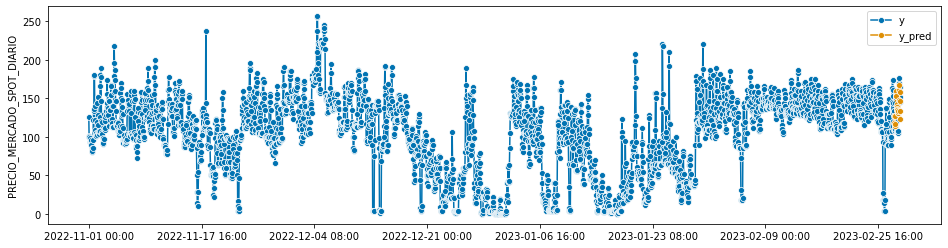

In [6]:
X = pd.concat([esios_spot.shift(24), esios_demand.shift(24)], axis=1)
X_na_rows = ~X.isna().any(axis=1)
X = X.dropna()

y = esios_spot[X_na_rows]
y_train, y_test, X_train, X_test = temporal_train_test_split(y, X, test_size=24)

forecaster.fit(y_train, X=X_train)
y_pred = forecaster.predict(fh=fh, X=X_test)
plot_series(esios_spot, y_pred, labels=["y", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred)

In [7]:
train_window_size_list = [2, 5, 7, 14, 30]
train_window_size_list = [24*x for x in train_window_size_list]

X = pd.concat([esios_spot.shift(24), esios_demand.shift(24)], axis=1)
X_na_rows = ~X.isna().any(axis=1)
X = X.dropna()

y = esios_spot[X_na_rows]

cv_results_list_demand = func.crossval_window_size(y, X, forecaster, train_window_size_list, forecasting_horizon)

/Users/pedrobedmar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/pedrobedmar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/pedrobedmar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/pedrobedmar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/pedrobedmar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in r

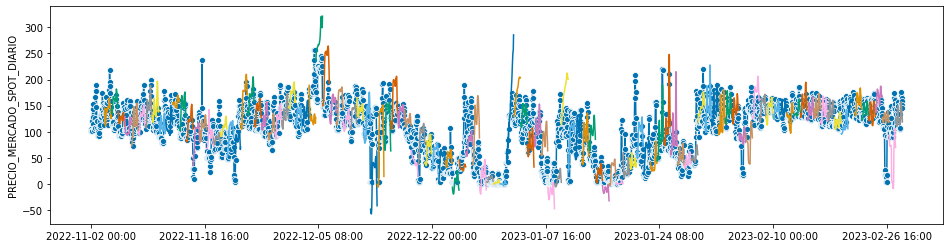

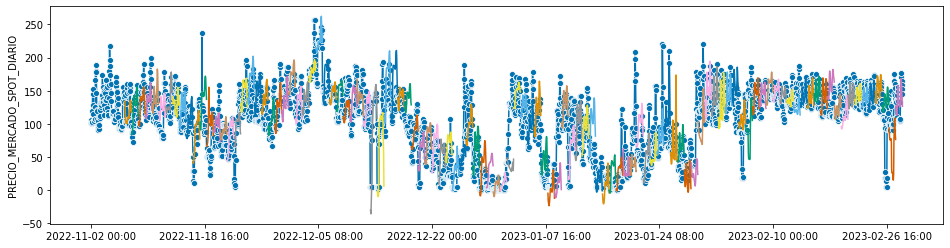

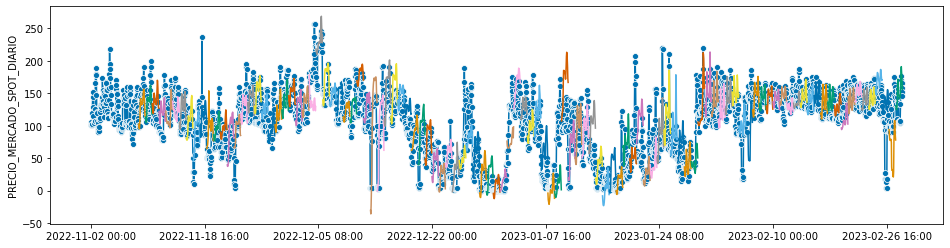

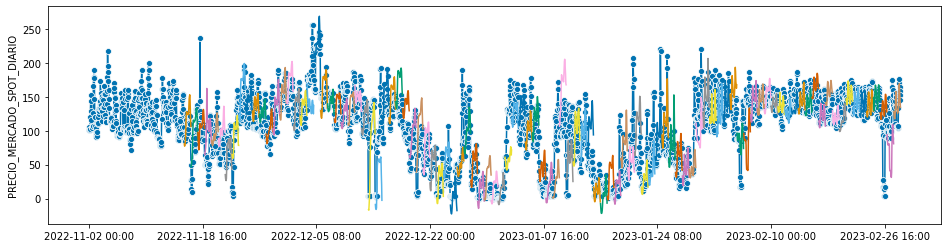

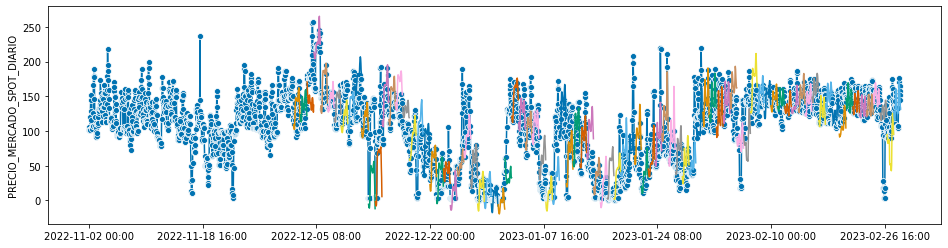

In [8]:
# visualization of a forecaster evaluation
func.crossval_plot_series(y, cv_results_list_demand)

In [9]:
cv_results_list_demand[0]

,test_MeanAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff,y_train,y_test,y_pred
0,0.157590,1.485699,0.013321,48,2022-11-03 23:00,2022-11-02 00:00 105.64 2022-11-02 01:00 ...,2022-11-04 00:00 147.25 2022-11-04 01:00 ...,2022-11-04 00:00 145.222459 2022-11-04 01:0...
1,0.291127,0.690774,0.013926,48,2022-11-04 23:00,2022-11-03 00:00 104.11 2022-11-03 01:00 ...,2022-11-05 00:00 133.79 2022-11-05 01:00 ...,2022-11-05 00:00 141.946680 2022-11-05 01:0...
2,0.216213,1.658752,0.013428,48,2022-11-05 23:00,2022-11-04 00:00 147.25 2022-11-04 01:00 ...,2022-11-06 00:00 130.36 2022-11-06 01:00 ...,2022-11-06 00:00 139.223372 2022-11-06 01:0...
3,0.146863,1.682740,0.013235,48,2022-11-06 23:00,2022-11-05 00:00 133.79 2022-11-05 01:00 ...,2022-11-07 00:00 103.80 2022-11-07 01:00 ...,2022-11-07 00:00 129.104124 2022-11-07 01:0...
4,0.092193,1.082895,0.013660,48,2022-11-07 23:00,2022-11-06 00:00 130.36 2022-11-06 01:00 ...,2022-11-08 00:00 88.01 2022-11-08 01:00 ...,2022-11-08 00:00 72.345910 2022-11-08 01:0...
...,...,...,...,...,...,...,...,...
112,0.089646,0.889194,0.014352,48,2023-02-23 23:00,2023-02-22 00:00 128.00 2023-02-22 01:00 ...,2023-02-24 00:00 128.82 2023-02-24 01:00 ...,2023-02-24 00:00 128.693257 2023-02-24 01:0...
113,0.171162,4.455766,0.016381,48,2023-02-24 23:00,2023-02-23 00:00 131.77 2023-02-23 01:00 ...,2023-02-25 00:00 145.30 2023-02-25 01:00 ...,2023-02-25 00:00 145.128249 2023-02-25 01:0...
114,3.875677,2.424021,0.013460,48,2023-02-25 23:00,2023-02-24 00:00 128.82 2023-02-24 01:00 ...,2023-02-26 00:00 130.00 2023-02-26 01:00 ...,2023-02-26 00:00 127.669524 2023-02-26 01:0...
115,0.567637,0.678589,0.013758,48,2023-02-26 23:00,2023-02-25 00:00 145.30 2023-02-25 01:00 ...,2023-02-27 00:00 97.60 2023-02-27 01:00 ...,2023-02-27 00:00 93.234436 2023-02-27 01:0...


In [10]:
cv_results_list_demand[1]

,test_MeanAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff,y_train,y_test,y_pred
0,0.152831,2.254341,0.015112,120,2022-11-06 23:00,2022-11-02 00:00 105.64 2022-11-02 01:00 ...,2022-11-07 00:00 103.80 2022-11-07 01:00 ...,2022-11-07 00:00 133.772847 2022-11-07 01:0...
1,0.117702,2.167919,0.014040,120,2022-11-07 23:00,2022-11-03 00:00 104.11 2022-11-03 01:00 ...,2022-11-08 00:00 88.01 2022-11-08 01:00 ...,2022-11-08 00:00 84.040543 2022-11-08 01:0...
2,0.059164,2.261817,0.014553,120,2022-11-08 23:00,2022-11-04 00:00 147.25 2022-11-04 01:00 ...,2022-11-09 00:00 101.75 2022-11-09 01:00 ...,2022-11-09 00:00 102.536981 2022-11-09 01:0...
3,0.095118,3.165726,0.013827,120,2022-11-09 23:00,2022-11-05 00:00 133.79 2022-11-05 01:00 ...,2022-11-10 00:00 114.52 2022-11-10 01:00 ...,2022-11-10 00:00 113.698991 2022-11-10 01:0...
4,0.172520,1.780632,0.018854,120,2022-11-10 23:00,2022-11-06 00:00 130.36 2022-11-06 01:00 ...,2022-11-11 00:00 135.29 2022-11-11 01:00 ...,2022-11-11 00:00 130.189793 2022-11-11 01:0...
...,...,...,...,...,...,...,...,...
109,0.044979,2.210131,0.016191,120,2023-02-23 23:00,2023-02-19 00:00 117.54 2023-02-19 01:00 ...,2023-02-24 00:00 128.82 2023-02-24 01:00 ...,2023-02-24 00:00 128.428506 2023-02-24 01:0...
110,0.096438,1.737085,0.016921,120,2023-02-24 23:00,2023-02-20 00:00 113.30 2023-02-20 01:00 ...,2023-02-25 00:00 145.30 2023-02-25 01:00 ...,2023-02-25 00:00 147.785233 2023-02-25 01:0...
111,4.187540,2.534260,0.015872,120,2023-02-25 23:00,2023-02-21 00:00 145.51 2023-02-21 01:00 ...,2023-02-26 00:00 130.00 2023-02-26 01:00 ...,2023-02-26 00:00 128.440723 2023-02-26 01:0...
112,0.468433,0.972981,0.018062,120,2023-02-26 23:00,2023-02-22 00:00 128.00 2023-02-22 01:00 ...,2023-02-27 00:00 97.60 2023-02-27 01:00 ...,2023-02-27 00:00 93.536379 2023-02-27 01:0...


In [11]:
train_window_size_list = [2, 5, 7, 14, 30, 45]
train_window_size_list = [24*x for x in train_window_size_list]

X = esios_df.loc[:, esios_df.columns != "PRECIO_MERCADO_SPOT_DIARIO"]
X = X.shift(24)
X_na_rows = ~X.isna().any(axis=1)
X = X.dropna()

y = esios_spot[X_na_rows]

cv_results_list_all_predictors = func.crossval_window_size(y, X, forecaster, train_window_size_list, forecasting_horizon)

/Users/pedrobedmar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/pedrobedmar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/pedrobedmar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/pedrobedmar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/pedrobedmar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: divide by zero encountered in r

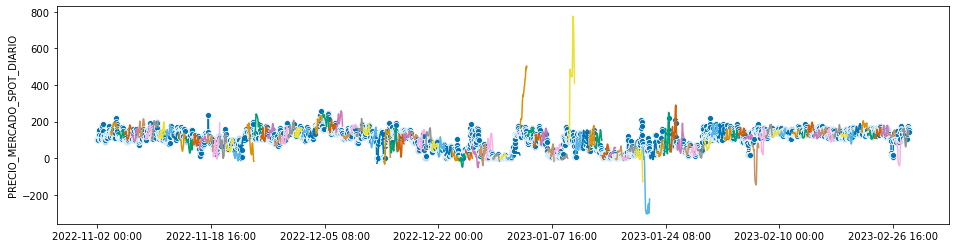

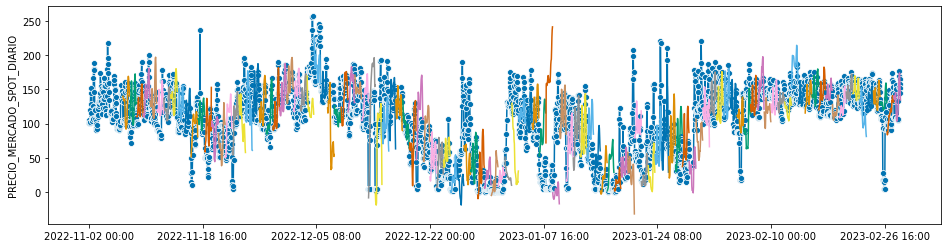

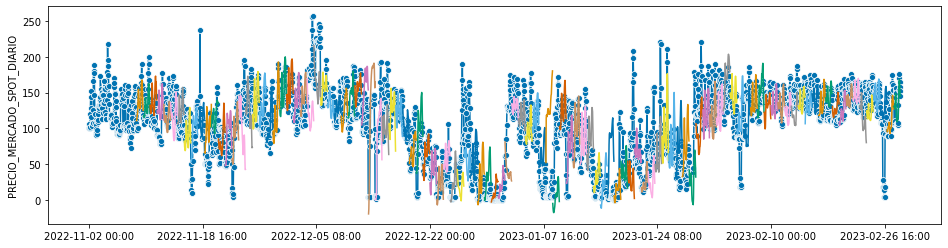

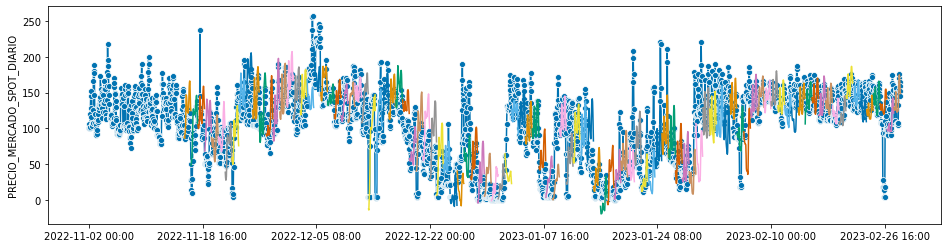

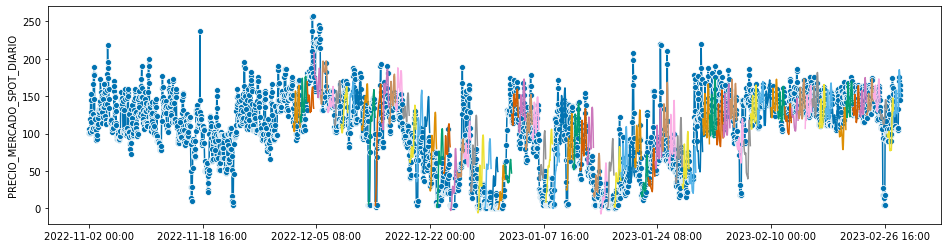

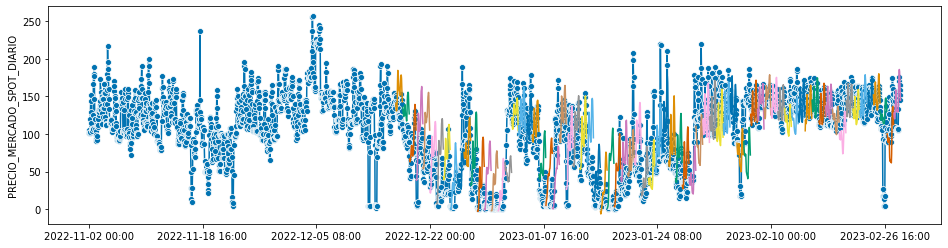

In [12]:
func.crossval_plot_series(y, cv_results_list_all_predictors)

In [13]:
for cv_results in cv_results_list_demand:
    mean_error = cv_results["test_MeanAbsolutePercentageError"].mean()
    print(mean_error)

7944477683831.547
143870684443074.75
212147295022918.84
262162074095058.8
373323382770697.5


In [14]:
for cv_results in cv_results_list_all_predictors:
    mean_error = cv_results["test_MeanAbsolutePercentageError"].mean()
    print(mean_error)

94737228408501.92
430707289347901.7
275281238436855.75
340279099869327.75
382053416794040.4
491603365025639.7


{'DEMANDA_REAL': 0.004214010471565345,
 'ar.L1': 0.7890972204877233,
 'ma.L1': -0.7933110678101305,
 'ma.L2': -0.09257298899046998,
 'sigma2': 201.27005731656007,
 'order': (1, 1, 2),
 'seasonal_order': (0, 0, 0, 0),
 'aic': 22094.601866235174,
 'aicc': 22094.6240473812,
 'bic': 22124.127230482667,
 'hqic': 22105.276913097594}

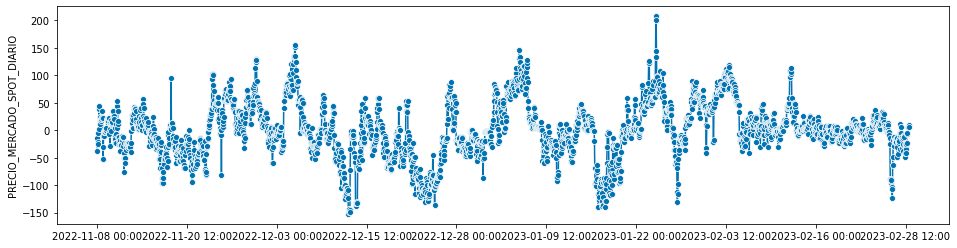

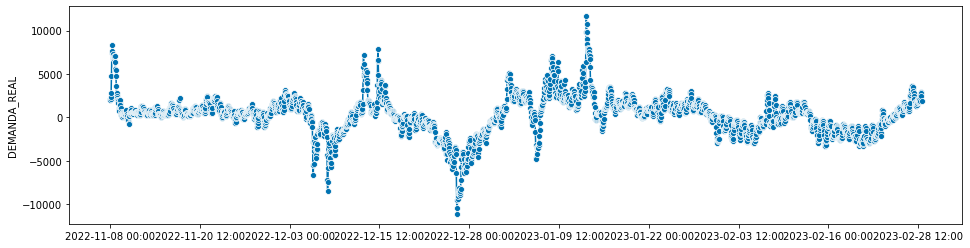

In [15]:
func.relation_between_response_and_predictor(esios_spot, esios_demand, diff_lag=24*7)

{'intercept': -0.01386182306728684,
 'GENERACIÓN_MEDIDA_TOTAL': 0.0022523258931855536,
 'ar.L1': -0.015936239623847742,
 'ar.L2': 0.8889732909827478,
 'ma.L1': 0.9345455725931139,
 'ma.L2': -0.05340495833033682,
 'sigma2': 168.97402685077088,
 'order': (2, 0, 2),
 'seasonal_order': (0, 0, 0, 0),
 'aic': 22895.849396424823,
 'aicc': 22895.88872226752,
 'bic': 22937.54963768904,
 'hqic': 22910.886437035897}

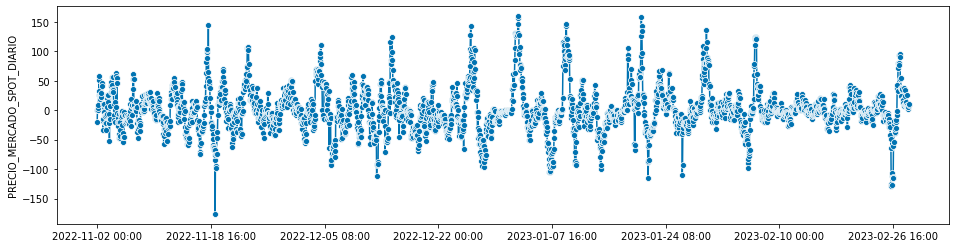

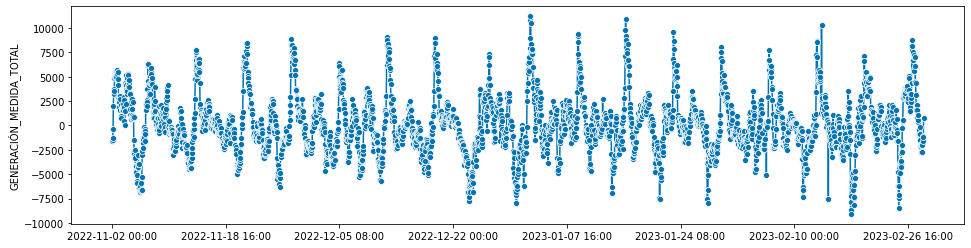

In [16]:
func.relation_between_response_and_predictor(esios_spot, esios_df.iloc[:,1], diff_lag=24)

{'GENERACIÓN_MEDIDA_CICLO_COMBINADO': 0.00300153911937147,
 'ar.L1': 0.9198756694257523,
 'sigma2': 179.7845714044655,
 'order': (1, 0, 0),
 'seasonal_order': (0, 0, 0, 0),
 'aic': 22940.516076997497,
 'aicc': 22940.524492144763,
 'bic': 22958.387608967874,
 'hqic': 22946.960522973674}

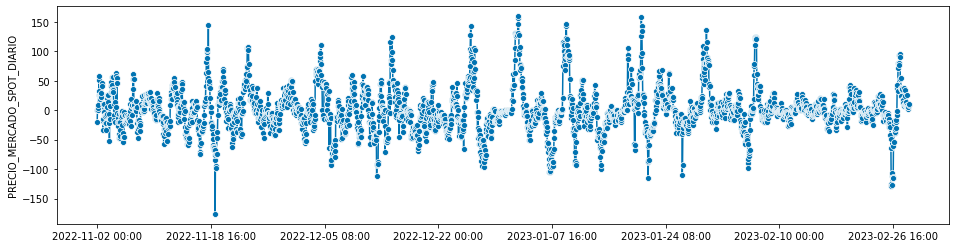

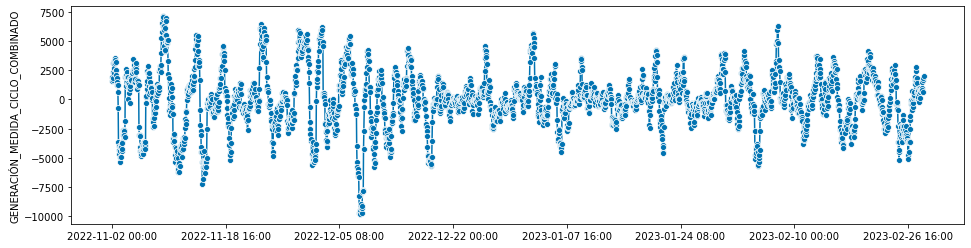

In [17]:
func.relation_between_response_and_predictor(esios_spot, esios_df.iloc[:,3], diff_lag=24)

{'GENERACIÓN_MEDIDA_NUCLEAR': 0.01872816224831672,
 'ar.L1': 0.9532141676537664,
 'ar.L2': -0.031642213166680706,
 'sigma2': 181.93261603321224,
 'order': (2, 0, 0),
 'seasonal_order': (0, 0, 0, 0),
 'aic': 22974.80779046202,
 'aicc': 22974.821820626872,
 'bic': 22998.636499755856,
 'hqic': 22983.40038509692}

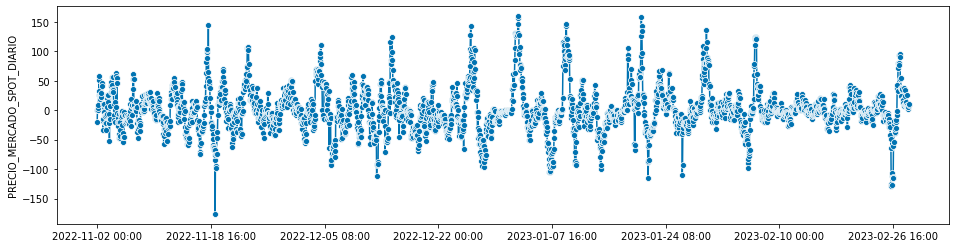

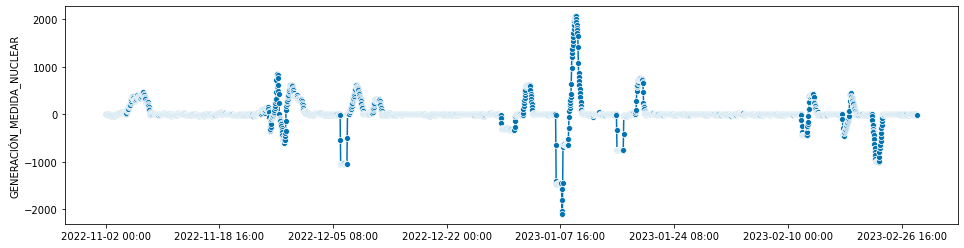

In [18]:
func.relation_between_response_and_predictor(esios_spot, esios_df.iloc[:,7], diff_lag=24)

{'intercept': -0.028589458417347897,
 'DEMANDA_REAL': 0.0031405326770475193,
 'GENERACIÓN_MEDIDA_EÓLICA_TERRESTRE': -0.002788589050692416,
 'GENERACIÓN_MEDIDA_CICLO_COMBINADO': -0.0009071001377824187,
 'GENERACIÓN_MEDIDA_DERIVADOS_DEL_PETRÓLEO_Ó_CARBÓN': 0.301613867071507,
 'GENERACIÓN_MEDIDA_GAS_NATURAL_COGENERACIÓN': 0.11008684896216946,
 'GENERACIÓN_MEDIDA_HIDRÁULICA': -0.0018977529486239185,
 'GENERACIÓN_MEDIDA_NUCLEAR': -0.009493212301805845,
 'GENERACIÓN_MEDIDA_SOLAR_FOTOVOLTAICA': -0.001460720234214821,
 'ar.L1': 1.4391317888464594,
 'ar.L2': -0.5905529964128649,
 'ar.L3': 0.10493542676094819,
 'ma.L1': -0.6367874966025001,
 'ma.L2': 0.060703595054792815,
 'sigma2': 134.42289890813404,
 'order': (3, 0, 2),
 'seasonal_order': (0, 0, 0, 0),
 'aic': 21988.854612167495,
 'aicc': 21989.023626252,
 'bic': 22078.212272019387,
 'hqic': 22021.076842048373}

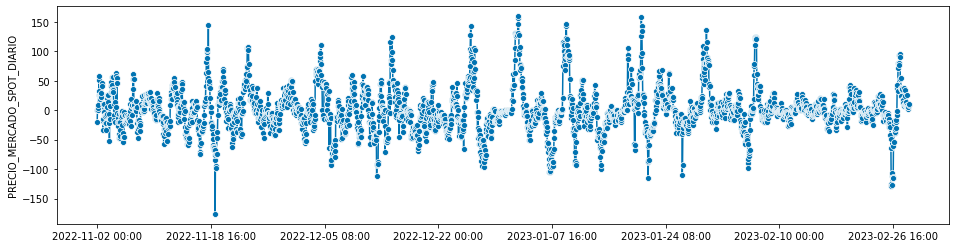

In [19]:
X = esios_df.drop(['PRECIO_MERCADO_SPOT_DIARIO', 'GENERACIÓN_MEDIDA_TOTAL'], axis=1)
func.relation_between_response_and_predictor(esios_spot, X, diff_lag=24)